[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NiCALab-IMAL/coadpative_BOTDA/blob/main/H2_Check_pfail.ipynb)

#Co-adaptive BCI based on supervised domain adaptation: results in motor imagery simulated data

Notebook credits: Valeria Spagnolo, Catalina Galván, Victoria Peterson

Instituto de Matemática Aplciada del Litoral, IMAL, UNL-CONICET



Notebooks related to the results presented in the X International BCI Meeting, Brussels, 2023

### Demo for testing H2: "BOTDA can make the adaption only if the EEG patterns provided by the user correspond to the mental task to be performed"

In [30]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [31]:
!pip3 install mne
!pip install POT
!git clone https://github.com/vpeterson/otda-mibci.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'otda-mibci' already exists and is not an empty directory.


In [32]:
import numpy as np
import sys
sys.path.insert(1, 'otda-mibci')
from MIOTDAfunctions import*
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import mne
from mne.decoding import CSP
mne.set_log_level(verbose='warning') #to avoid info at terminal
from  random import sample
from sklearn.metrics import balanced_accuracy_score


In [33]:
# function to run BOTDA with groupLASSO regularization
def Backward_GroupLasso_Transport(Gtr_daot, Ytr_daot, regu_, Gtr, Ytr, Gval, Yval, Gte, lda, metric):
      
    botda = ot.da.SinkhornL1l2Transport(metric=metric, reg_e=regu_[0], reg_cl=regu_[1])
    # learn params of transport
    botda.fit(Xs=Gval, ys=Yval, Xt=Gtr_daot)
    botda_matrix = botda.coupling_
    #transport testing samples
    transp_Xt_backward=botda.transform(Xs=Gte)
    
    # Compute accuracy without retraining    
    yt_predict = lda.predict(transp_Xt_backward) 
    
    return yt_predict, transp_Xt_backward, botda_matrix

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import os.path as op
data_path = op.join('/content/drive/MyDrive/coadaptivesimdata/')

# Training data: Session 1 (%ERD = 50), 0% of failed trials

In [36]:
# %% Load Training data - session 1
Data_S1 = op.join(data_path, 'session1.fif')
epochs_S1 = mne.read_epochs(Data_S1, preload=True, verbose=False)
# resample to 250 Hz
epochs_S1 = epochs_S1.resample(250)
epochs_S1_array = epochs_S1.get_data()  # Epoched data as a numpy array
# filter data between 8 an 30 hz
epochs_S1_array=mne.filter.filter_data(epochs_S1_array, 250, 8, 30);


In [37]:
#%% Training - Learn CSP+LDA from source data
Xtr = epochs_S1_array
Ytr = epochs_S1.events[:,2]
csp = CSP(n_components=2, reg='empirical', log=True, norm_trace=False, cov_est='epoch') #creating obj
#learn csp filters
Gtr = csp.fit_transform(Xtr, Ytr)
#learn lda
lda = LinearDiscriminantAnalysis()
lda.fit(Gtr,Ytr)

LinearDiscriminantAnalysis()

In [38]:
# print LDA score, we expect it to be high
lda.score(Gtr,Ytr)

1.0

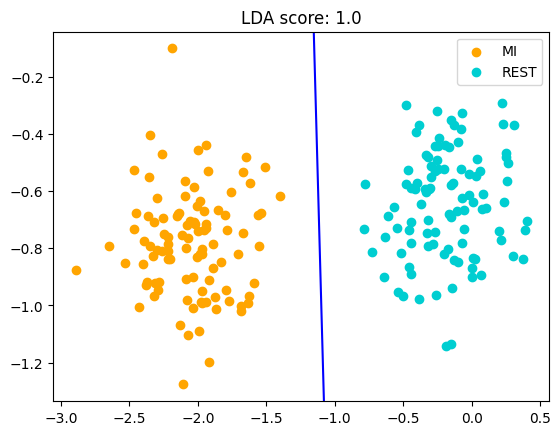

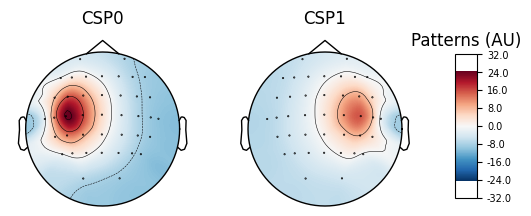

In [39]:
#Plot first 2 features of the training set + the LDA decision boundary
features = Gtr[:,0:2]
fig, axs = plt.subplots()
axs.scatter(features[Ytr==1, 0], features[Ytr==1, 1], c='orange', label='MI')
axs.scatter(features[Ytr==2, 0], features[Ytr==2, 1], c='darkturquoise', label='REST')
axs.set_title("LDA score: " + str(lda.score(Gtr,Ytr)))
axs.legend()
b, w1, w2 = lda.intercept_[0], lda.coef_[0][0], lda.coef_[0][1]
xx = np.array(axs.get_xlim())
xlim = xx
ylim = np.array(axs.get_ylim())
axs.plot(xx, -(b+xx*w1)/w2, c='blue')
axs.set_ylim(ylim)
axs.set_xlim(xlim)
plt.show()

fig = csp.plot_patterns(epochs_S1.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

# Test on session 2 (ERD = 0.45) with 10% of failed trials

In [40]:
#load testing session
Data_S2 = op.join(data_path, 'session2.fif') 
epochs_S2 = mne.read_epochs(Data_S2, preload=True, verbose=False)
# resample to 250 Hz
epochs_S2 = epochs_S2.resample(250)
epochs_S2_array = epochs_S2.get_data()
# Filter data 
epochs_S2_array=mne.filter.filter_data(epochs_S2_array, 250, 8, 30)

Xte = epochs_S2_array
Yte = epochs_S2.events[:,2]

In [41]:
#%% OTDA parameters
rango_cl=[0.1, 1, 10]
rango_e=[0.1, 1, 10] 
metric = 'sqeuclidean'
outerkfold = 20
innerkfold = None
M=20
norm=None
eps = 1e+6

In [42]:
# select source subset
# Use the first 20 trials as the validation set
Xval=Xte[0:20].copy()
Yval=Yte[0:20].copy()
# features val
Gval=csp.transform(Xval)
G_BOTDAl1l2_, Y_BOTDAl1l2_, regu_BOTDAl1l2_=\
SelectSubsetTraining_BOTDAl1l2(Gtr, Ytr, Gval, Yval, rango_e, rango_cl, lda, metric, outerkfold, innerkfold, M, norm)

In [43]:
# create MI failed trials
Yte_new = Yte[20:].copy() #avoid the first 20 trials of val
Xte_new = Xte[20:].copy()

p = 0.1   # proportion of failed trials
idx = np.where(Yte_new == 2)[0] #only in testing idx    
n_change = np.array(sample(list(idx), int(p*len(idx))))
Yte_new[n_change] = 1
Gte=csp.transform(Xte_new)

In [44]:
# evaluate LDA accuracy
acc_lda  = []
y_predict_lda = lda.predict(Gte)

acc_lda = balanced_accuracy_score(Yte_new, y_predict_lda)

In [45]:
# BOTDA
acc_OT = []  
yt_predict = []
Transp = []
Xval_ot = Xval.copy()
Yval_ot = Yval.copy()
#  For each sample, make the data adaptation
for re in range(len(Yte_new)):
    
    #testing trial
    Xte_ot=Xte_new[re:re+1]
    Yte_ot=Yte_new[re:re+1]
    
    Xval_ot=np.vstack((Xval_ot, Xte_ot))
    Yval_ot=np.hstack((Yval_ot, Yte_ot))
    
    #csp estimation
    Gval_ot=csp.transform(Xval_ot)
    Gte_ot=csp.transform(Xte_ot)
  
    yt_pred, transp_Xt_backward, botda_matrix = Backward_GroupLasso_Transport(G_BOTDAl1l2_, Y_BOTDAl1l2_, regu_BOTDAl1l2_, Gtr, Ytr, Gval_ot, Yval_ot, Gte_ot, lda, metric)
    yt_predict.append(yt_pred)
    #save transported data
    Transp.append(transp_Xt_backward)
  
Gte_ot=np.squeeze(Transp)
yt_predict = np.squeeze(yt_predict)
acc_OT = balanced_accuracy_score(Yte_new, yt_predict) #########

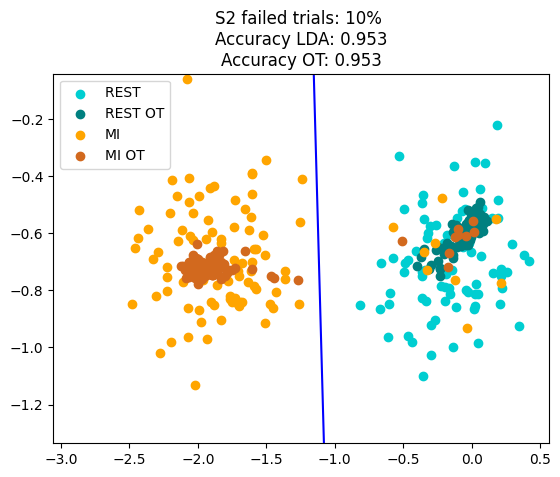

In [46]:
#Plot first 2 features
ft = Gte[:,0:2]
ft_ot = Gte_ot[:,0:2]

x = np.linspace(-1,3,500)
y = np.linspace(2,8,500)
X,Y = np.meshgrid(x,y)
pos = np.array([X.flatten(),Y.flatten()]).T
fig, axs = plt.subplots()
axs.scatter(ft[Yte_new==2, 0], ft[Yte_new==2, 1], c='darkturquoise', label='REST ')  
axs.scatter(ft_ot[Yte_new==2, 0], ft_ot[Yte_new==2, 1], c='teal', label='REST OT')
axs.scatter(ft[Yte_new==1, 0], ft[Yte_new==1, 1], c='orange', label='MI')  
axs.scatter(ft_ot[Yte_new==1, 0], ft_ot[Yte_new==1, 1], c='chocolate', label='MI OT')  

axs.set_title('S2 failed trials: 10% ' + '\nAccuracy LDA: ' + str(acc_lda)[:5] + '\nAccuracy OT: ' + str(acc_OT)[:5])
axs.legend(loc='upper left')               
b, w1, w2 = lda.intercept_[0], lda.coef_[0][0], lda.coef_[0][1]
xx = np.array(axs.get_xlim())
axs.plot(xx, -(b+xx*w1)/w2, c='blue')
axs.set_ylim(ylim)
axs.set_xlim(xlim)
plt.show()

And we if the user does not provided brain patterns that correspond to the indicated mental task, BOTDA cannot help into the decoding

